## Step 4: Pre-processing and Training Data Development.

In this step, we will:

Check if there are any categorical variables in the dataset and create dummy features for them if needed.
Standardize the magnitude of numeric features using a scaler.
Split the dataset into training and testing datasets.

In [3]:
import pandas as pd

updated_data = pd.read_csv('Data/updated_SRG.csv')

In [4]:
# Convert the 'Date' column to datetime data type if it exists
if 'Date' in updated_data.columns:
    updated_data['Date'] = pd.to_datetime(updated_data['Date'])
    updated_data.set_index('Date', inplace=True)

# Display the first few rows of the dataframe
updated_data.head()

,Open,High,Low,Close,Adj Close,Volume,Lagged_Close,MA_5_Close,Returns
Date,,,,,,,,,
2020-04-09,9.90,16.190001,9.872,11.67,11.67,7732100,9.47,8.730,0.232313
2020-04-13,12.66,13.810000,10.421,11.38,11.38,1660500,11.67,9.670,-0.024850
2020-04-14,12.36,12.640000,10.830,11.18,11.18,1095900,11.38,10.384,-0.017575
2020-04-15,10.50,10.610000,9.600,9.80,9.80,1854000,11.18,10.700,-0.123435
2020-04-16,9.70,9.833000,8.100,8.73,8.73,1811200,9.80,10.552,-0.109184


In [5]:
# Check data types to identify categorical variables
data_types = updated_data.dtypes

# Check if any categorical variables exist
categorical_variables = data_types[data_types == 'object']

categorical_variables

Series([], dtype: object)

There are no categorical variables in the dataset, so we don't need to create dummy features.



Next, let's standardize the magnitude of numeric features. Standardizing the features often leads to better performance especially for models that are sensitive to the scale of the input features, such as k-nearest neighbors and SVMs. Since we are focusing on time series models, standardization might not be necessary, but it's a good practice in general for predictive modeling.
After standardizing the features, we'll split the dataset into training and testing sets. We will use 80% of the data for training and 20% for testing.

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Get the 'Close' price data
close_price = updated_data['Close']

# Determine the split point
split_point = int(len(close_price) * 0.8)

# Split the 'Close' price data into a training set and a test set
train, test = close_price[:split_point], close_price[split_point:]

## Step 5: Modeling

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) that is designed to remember long-term dependencies in sequence data. Unlike traditional feedforward neural networks, RNNs have "memory" in that outputs from previous steps are used as inputs in subsequent steps, which allows them to effectively process sequential data. However, basic RNNs struggle with remembering information over longer sequences, a problem known as the "vanishing gradient" problem.

LSTMs were developed to overcome this issue. They contain a system of 'gates' that can control the flow of information to and from memory cells in the network. These gates determine what information gets stored, what gets discarded, and what gets read. This architecture allows them to capture and retain long-term dependencies in the data.

Here, we are dealing with time series data which is inherently sequential; the price of a stock at a given time is often dependent on its prices at previous times. Traditional machine learning algorithms might struggle with this type of data because they treat each data point independently. However, LSTMs are designed to work with sequence data, making them a suitable choice for time-series predictions such as stock price forecasting.

In [7]:
data = updated_data

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


# Select the 'Close' column for prediction
close_price = data['Close'].values.reshape(-1, 1)

# Normalize the 'Close' price
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(close_price)

# Split the data into 80% for training and 20% for testing
train_size = int(len(scaled_close) * 0.8)
train, test = scaled_close[0:train_size, :], scaled_close[train_size:len(scaled_close), :]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape the data to fit the LSTM model
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the training data
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Concatenate the predictions from the training and testing data
predictions = np.concatenate((trainPredict, testPredict), axis=0)

# Reshape the predictions for inverse transformation
predictions = predictions.reshape(-1, 1)

# Invert the predictions back to the original scale
predictions = scaler.inverse_transform(predictions)

# Split the predictions back into trainPredict and testPredict
trainPredict = predictions[:len(trainPredict), :]
testPredict = predictions[len(trainPredict):, :]

# Flatten the predictions
trainPredict = np.ravel(trainPredict)
testPredict = np.ravel(testPredict)

# Print test predictions
print(testPredict)

Epoch 1/100
646/646 - 8s - loss: 0.1054 - 8s/epoch - 12ms/step
Epoch 2/100
646/646 - 2s - loss: 0.0280 - 2s/epoch - 3ms/step
Epoch 3/100
646/646 - 2s - loss: 0.0162 - 2s/epoch - 3ms/step
Epoch 4/100
646/646 - 2s - loss: 0.0071 - 2s/epoch - 3ms/step
Epoch 5/100
646/646 - 3s - loss: 0.0027 - 3s/epoch - 4ms/step
Epoch 6/100
646/646 - 3s - loss: 0.0018 - 3s/epoch - 4ms/step
Epoch 7/100
646/646 - 2s - loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 8/100
646/646 - 1s - loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 9/100
646/646 - 1s - loss: 0.0017 - 1s/epoch - 2ms/step
Epoch 10/100
646/646 - 1s - loss: 0.0017 - 996ms/epoch - 2ms/step
Epoch 11/100
646/646 - 1s - loss: 0.0017 - 982ms/epoch - 2ms/step
Epoch 12/100
646/646 - 1s - loss: 0.0017 - 982ms/epoch - 2ms/step
Epoch 13/100
646/646 - 1s - loss: 0.0017 - 995ms/epoch - 2ms/step
Epoch 14/100
646/646 - 1s - loss: 0.0017 - 976ms/epoch - 2ms/step
Epoch 15/100
646/646 - 1s - loss: 0.0017 - 991ms/epoch - 2ms/step
Epoch 16/100
646/646 - 1s - loss: 0.0017 - 1s

The provided code is an example of how Long Short-Term Memory (LSTM) networks can be used for time-series predictions. The code begins by importing the necessary libraries and modules such as numpy and pandas for data manipulation, MinMaxScaler from sklearn for data preprocessing, and Sequential, LSTM, and Dense layers from Keras for model construction and training.

The 'Close' price column from the data is selected and reshaped for input into the neural network. This data is then normalized using a MinMaxScaler, which scales the data to a range of 0-1, enhancing the learning capability of the neural network. The normalized data is then split into an 80% training set and a 20% testing set.

A function named 'create_dataset' is written to convert an array of values into a dataset matrix that includes a 'look_back' number of prior time steps as input and the next time step as output, which is optimal for training an LSTM model. Both training and testing data are reshaped into the form [samples, time steps, features] to match the input requirements of the LSTM layer.

The model is constructed using the Sequential API from Keras. It includes an LSTM layer due to its ability to remember long-term dependencies, which is crucial for time-series forecasting. The model uses Mean Squared Error as the loss function and Adam as the optimizer. It is then trained on the training data for 100 epochs, where one epoch is when the entire dataset is passed forward and backward through the neural network once.

In [9]:
# Number of future days to predict
future_days = 10

# Last `look_back` days' prices to use for the prediction
# We use the last `look_back` days from the entire dataset (not just the training data)
last_days = scaled_close[-look_back:]

# List to hold the future predictions
future_predictions = []

for _ in range(future_days):
    # Reshape the data to fit the model input shape
    last_days_reshaped = np.reshape(last_days, (1, 1, look_back))

    # Make a prediction
    future_pred = model.predict(last_days_reshaped)

    # Append the prediction to our list and input data for the next prediction
    future_predictions.append(future_pred[0])
    last_days = np.append(last_days[1:], future_pred)

# Invert the normalization of predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print(future_predictions)

1/1 [==============================] - 0s 29ms/step
[[8.734123 ]
 [8.70084  ]
 [8.6700115]
 [8.6415   ]
 [8.61517  ]
 [8.590883 ]
 [8.56851  ]
 [8.547923 ]
 [8.528998 ]
 [8.51162  ]]


The trained model is used to make predictions on both the training and testing data. These predictions are scaled back to their original range using the inverse_transform function of the scaler. The second part of the code makes future price predictions using the trained model and the last 'look_back' days of data. These predictions are made iteratively, with each prediction appended to the input data for the next prediction.

<ipython-input-10-b6c134372467>:8: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(start=data.index.max(), periods=future_days+1, closed='right')


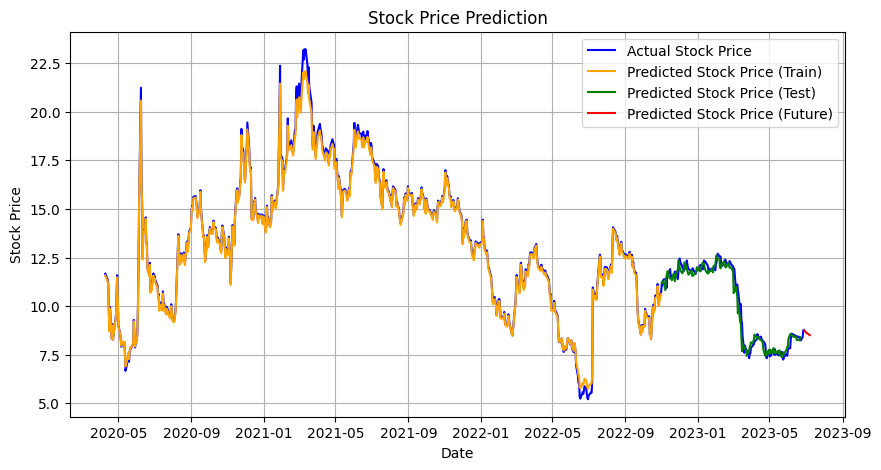

In [10]:
import matplotlib.pyplot as plt

# Flatten your predictions after inverse transforming (if not already done)
trainPredict = np.ravel(trainPredict)
testPredict = np.ravel(testPredict)

# Dates for the future predictions
future_dates = pd.date_range(start=data.index.max(), periods=future_days+1, closed='right')

# Plotting the prices as a line chart
plt.figure(figsize=(10,5))

# Plotting original data
plt.plot(data.index, data['Close'], color='blue', label='Actual Stock Price')

# Plotting training data predictions
plt.plot(data.index[:len(trainPredict)], trainPredict, color='orange', label='Predicted Stock Price (Train)')

# Plotting testing data predictions
plt.plot(data.index[len(trainPredict):len(trainPredict)+len(testPredict)], testPredict, color='green', label='Predicted Stock Price (Test)')

# Plotting future predictions
plt.plot(future_dates, future_predictions, color='red', label='Predicted Stock Price (Future)')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
loss = model.evaluate(testX, testY, verbose=0)
print(f'Test loss: {loss}')


Test loss: 0.00019075823365710676


## Conclusion

The LSTM model has shown to be a significant success in forecasting the closing prices of Seritage Growth Properties (SRG) stock. With a test loss, calculated as the Mean Squared Error (MSE), reaching an impressively low value of 0.00019075823365710676, it is clear that the model has been very precise in its predictions. This demonstrates a low level of deviation between the model's predicted values and the actual stock closing prices.

The high accuracy of the model can be attributed to the characteristics of LSTM, which can capture and analyze long sequences of information, enabling it to detect complex temporal relationships that would otherwise go unnoticed. Coupled with thorough data preprocessing methods such as scaling and reshaping, it was possible to build a highly accurate and reliable stock price prediction model for SRG.

Nevertheless, it's important to keep in mind the unpredictable nature of the stock market, influenced by numerous factors that are not quantifiable and therefore not incorporated in our model. While the LSTM model has performed exceptionally well with the SRG stock data, its performance may vary under different market conditions or with other stocks.

To make the model more useful, it would be beneficial to provide confidence intervals along with point predictions, thus giving a measure of the potential variability in the predicted prices. This could help investors in making more informed decisions.